# Threshold moving for Logistic Regression Models

In [124]:
import pip
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from matplotlib import pyplot
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from numpy import mean
from numpy import std
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix as confusion
from sklearn.metrics import recall_score as recall
from sklearn.metrics import confusion_matrix
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV as CCCV
from sklearn.calibration import calibration_curve
from sklearn.pipeline import Pipeline
from numpy import nanargmax
InteractiveShell.ast_node_interactivity = "all"

In [125]:
#Defining the search space for all LR models
space=dict()
space['solver']=['newton-cg', 'lbfgs', 'liblinear']
space['penalty']=['none', 'l1', 'l2', 'elasticnet']
space['C']=[100, 10, 1, 0.1, 0.01]
#Defining model parameters
LR= LogisticRegression(random_state=26)
cv=KFold(n_splits=5, shuffle=True, random_state=26)
searchLR=RandomizedSearchCV(LR, space, scoring='roc_auc', n_jobs=-1,n_iter=30, refit=True, random_state=26)

## Suicidal ideation threshold moving

In [126]:
#Dividing the training dataset using stratified split for threshold moving 
Xi=pd.read_csv('Xi.csv')
y=pd.read_csv('y_si.csv')
X55, X15, y55, y15=train_test_split(Xi, y, test_size=0.15, random_state=26, stratify=y)

In [127]:
y55=y55.values.flatten()
y15=y15.values.flatten()
np.average(y)

0.13301942319011184

In [128]:
X55.to_csv('X55_si.csv', index=False)
X15.to_csv('X15_si.csv', index=False)
np.savetxt('y55_si.csv', y55, delimiter=',')
np.savetxt('y15_si.csv', y15, delimiter=',')

In [129]:
#Hyperparameter optimisation: note that some fits will fail because of solver-penalty incompatibilities in some hyperparameter combinations
searchLR.fit(X55, y55)
searchLR.best_params_

KeyboardInterrupt: 

In [ ]:
#Calibrating the best classifier
cLR=CCCV(searchLR.best_estimator_, method='isotonic')
cLR.fit(X55, y55)
LR_probac=cLR.predict_proba(X55)

CalibratedClassifierCV(estimator=LogisticRegression(C=0.1, penalty='l1',
                                                    random_state=26,
                                                    solver='liblinear'),
                       method='isotonic')

In [ ]:
LR_probac=LR_probac[:, 1]
print('Probs: %.3f (%.3f)' % (mean(LR_probac), std(LR_probac)) )

Probs: 0.134 (0.123)


In [ ]:
#Creating a function that displays fpr, tpr, ROC curve, AUROC, and best threshold 
def tuning(y55, LR_probac):
    fpr, tpr, thresholds=roc_curve(y55, LR_probac)
    #Calculating AUROC in training data
    print(f'AUROC={roc_auc_score(y55, LR_probac):f}')
    #Deriving the optimal threshold using Youden's J statistic 
    J = tpr - fpr
    ix = nanargmax(J)
    best_thresh = thresholds[ix]
    print('Best Threshold=%f' % (best_thresh))
    # plot the roc curve for the model, 
    pyplot.plot([0,1], [0,1], linestyle='--', label='Baseline')
    pyplot.plot(fpr, tpr, marker='.', label='LR')
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.show()

    return best_thresh

AUROC=0.907323
Best Threshold=0.188868


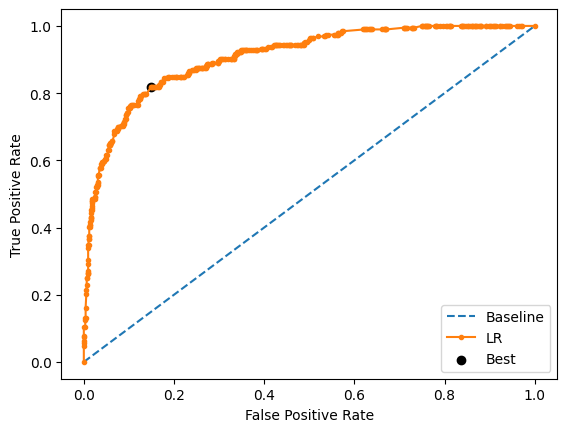

In [ ]:
best_thresh=tuning(y55, LR_probac)

In [ ]:
#Defining a function that displays probability thresholds by percentiles
def threshp():
    for i in np.arange(80, 100, 5):
        print("Top", 100-i, "% of predicted risk=", np.percentile(LR_probac, i) )

threshp()

Top 20 % of predicted risk= 0.20278725846534185
Top 15 % of predicted risk= 0.25276992201910126
Top 10 % of predicted risk= 0.30907975202037713
Top 5 % of predicted risk= 0.41504813392137335


In [ ]:
yprob=cLR.predict_proba(X15)
yprob=yprob[:, 1]
print('Probs: %.3f (%.3f)' % (mean(yprob), std(yprob)) )

In [ ]:
#Defining a function to examine calibration curve
def ccurve(y15, yprob, n_bins=10):
    # reliability diagram
    fop, mpv = calibration_curve(y15, yprob, n_bins=10)
    # plot perfectly calibrated
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pyplot.xlabel('Predicted probability')
    pyplot.ylabel('True probability')
    pyplot.plot(mpv, fop, marker='.')
    pyplot.show()

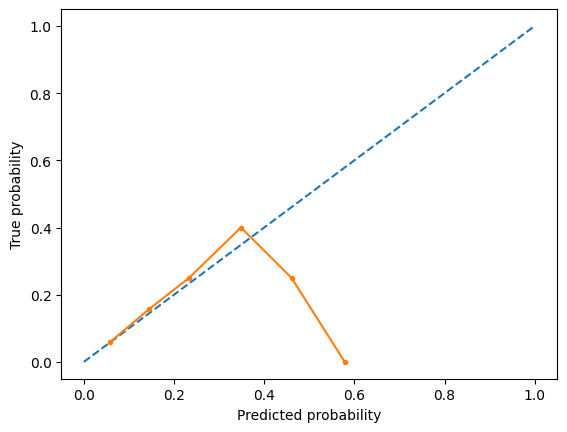

In [ ]:
ccurve(y15, yprob)

In [ ]:
#Creating a function which evaluates the best theshold derived from Youden's
def eval(y15, yprob, best_thresh):
    ypredcLR=np.where(yprob>best_thresh, 1, 0)
    f1= f1_score(y15, ypredcLR)
    print(f'F1= {f1:f}')
    sens= recall(y15, ypredcLR)
    print(f'Sensitivity= {sens:f}')
    tn, fp, fn, tp= confusion(y15, ypredcLR).ravel()
    spec=tn/(tn+fp)
    print(f'Specificity= {spec:f}')
    auc= roc_auc_score(y15, yprob)
    print(f'AUROC= {auc:f}')

    return f1, auc, sens, spec

eval(y15, yprob, best_thresh)


F1= 0.344086
Sensitivity= 0.470588
Specificity= 0.805430
AUROC= 0.708744


(0.3440860215053763,
 0.7087436784668618,
 0.47058823529411764,
 0.8054298642533937)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

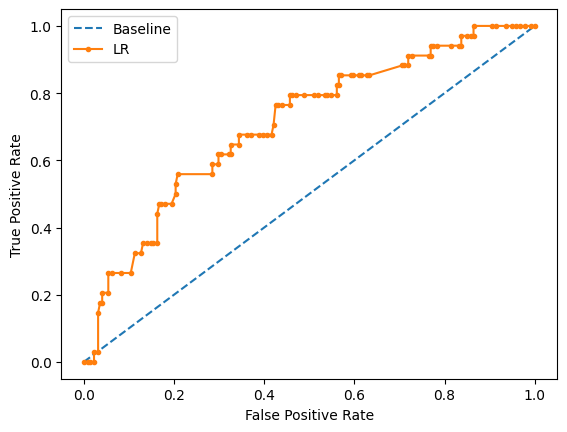

In [ ]:
fpr, tpr, thresholds=roc_curve(y15, yprob)    
# plot the roc curve for the model, 
pyplot.plot([0,1], [0,1], linestyle='--', label='Baseline')
pyplot.plot(fpr, tpr, marker='.', label='LR')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


### Self-harm threshold moving

In [ ]:
#Dividing the training dataset using stratified split for threshold moving 
Xi=pd.read_csv('Xi.csv')
Xi=Xi.drop('Unnamed: 0', axis=1)

y=pd.read_csv('y_nssi.csv')
X55, X15, y55, y15=train_test_split(Xi, y, test_size=0.15, random_state=26, stratify=y)

X55.to_csv('X55_nssi.csv', index=False)
X15.to_csv('X15_nssi.csv', index=False)
y55.to_csv('y55_nssi.csv', index=False)
y15.to_csv('y15_nssi.csv', index=False)
Xi.to_csv('Xi.csv', index=False)

In [ ]:
y55=y55.values.flatten()
y15=y15.values.flatten()
np.average(y)

0.07710417892878163

In [ ]:
#Hyperparameter optimisation: note that some fits will fail because of solver-penalty incompatibilities in some hyperparameter combinations
searchLR.fit(X55, y55)
searchLR.best_params_

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
85 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\User

RandomizedSearchCV(estimator=LogisticRegression(random_state=26), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01],
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   random_state=26, scoring='roc_auc')

{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01}

In [ ]:
#Calibrating the best classifier
cLR=CCCV(searchLR.best_estimator_, method='isotonic')
cLR.fit(X55, y55)
LR_probac=cLR.predict_proba(X55)
LR_probac=LR_probac[:, 1]

CalibratedClassifierCV(estimator=LogisticRegression(C=0.01, random_state=26,
                                                    solver='liblinear'),
                       method='isotonic')

In [ ]:
print('Probs: %.5f (%.5f)' % (mean(LR_probac), std(LR_probac)) )

Probs: 0.07781 (0.09776)


AUROC=0.968539
Best Threshold=0.138621


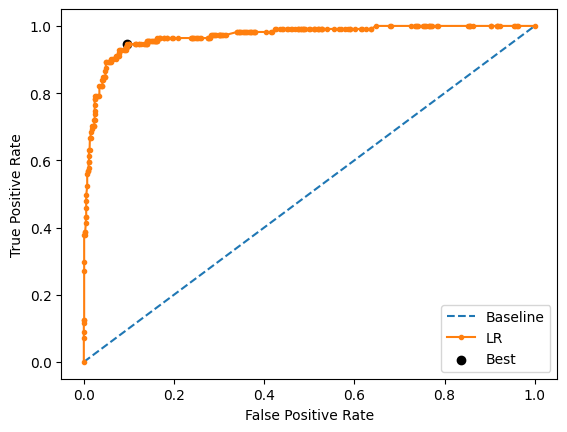

In [ ]:
best_thresh=tuning(y55, LR_probac)

In [ ]:
#Defining a function that displays probability thresholds by percentiles
def threshp():
    for i in np.arange(80, 100, 5):
        print("Top", 100-i, "% of predicted risk=", np.percentile(LR_probac, i) )

threshp()

Top 20 % of predicted risk= 0.10524934706870191
Top 15 % of predicted risk= 0.14818864447404972
Top 10 % of predicted risk= 0.21979514750482496
Top 5 % of predicted risk= 0.2831800766283525


In [ ]:
yprob=cLR.predict_proba(X15)
yprob=yprob[:, 1]
print('Probs: %.3f (%.3f)' % (mean(yprob), std(yprob)) )

Probs: 0.083 (0.104)


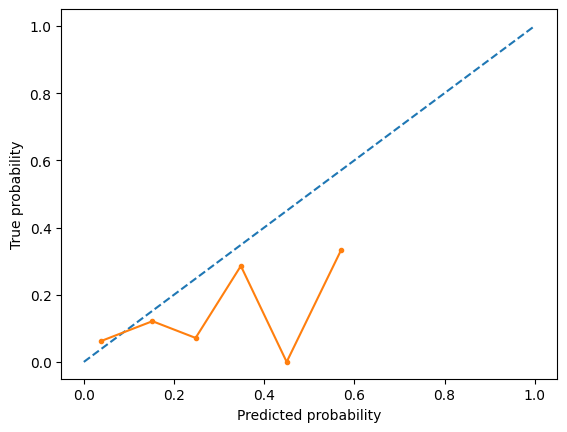

In [ ]:
ccurve(y15, yprob)

In [ ]:
eval(y15, yprob, best_thresh)


F1= 0.231884
Sensitivity= 0.400000
Specificity= 0.825532
AUROC= 0.665213


(0.23188405797101447, 0.6652127659574468, 0.4, 0.825531914893617)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

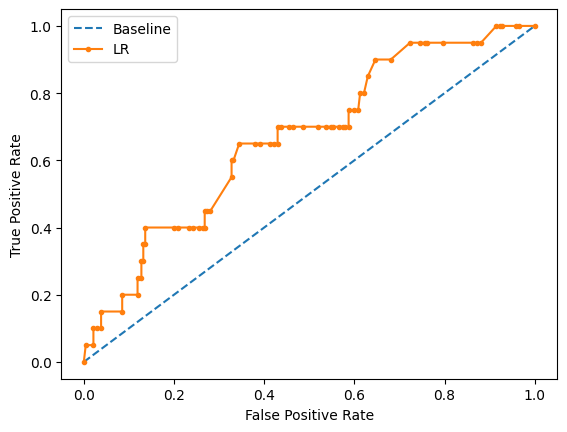

In [ ]:
fpr, tpr, thresholds=roc_curve(y15, yprob)    
# plot the roc curve for the model, 
pyplot.plot([0,1], [0,1], linestyle='--', label='Baseline')
pyplot.plot(fpr, tpr, marker='.', label='LR')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()


### Attempt threshold moving

In [130]:
#Dividing the training dataset using stratified split for threshold moving 
Xi=pd.read_csv('Xi.csv')
y=pd.read_csv('y_att.csv')
X55, X15, y55, y15=train_test_split(Xi, y, test_size=0.15, random_state=26, stratify=y)

X55.to_csv('X55_att.csv', index=False)
X15.to_csv('X15_att.csv', index=False)
y55.to_csv('y55_att.csv', index=False)
y15.to_csv('y15_att.csv', index=False)

In [131]:
y55=y55.values.flatten()
y15=y15.values.flatten()
np.average(y)

0.0429664508534432

In [132]:
#Hyperparameter optimisation: note that some fits will fail because of solver-penalty incompatibilities in some hyperparameter combinations
searchLR.fit(X55, y55)
searchLR.best_params_

c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
85 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\z5291979\OneDrive - UNSW\Documents\lsac-data\lsac-suicidality\venv\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\User

RandomizedSearchCV(estimator=LogisticRegression(random_state=26), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01],
                                        'penalty': ['none', 'l1', 'l2',
                                                    'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   random_state=26, scoring='roc_auc')

{'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01}

In [133]:
#Calibrating the best classifier
cLR=CCCV(searchLR.best_estimator_, method='isotonic')
cLR.fit(X55, y55)
LR_probac=cLR.predict_proba(X55)
LR_probac=LR_probac[:, 1]

CalibratedClassifierCV(estimator=LogisticRegression(C=0.01, random_state=26,
                                                    solver='liblinear'),
                       method='isotonic')

In [134]:
print('Probs: %.5f (%.5f)' % (mean(LR_probac), std(LR_probac)) )

Probs: 0.04520 (0.05873)


AUROC=0.983544
Best Threshold=0.074037


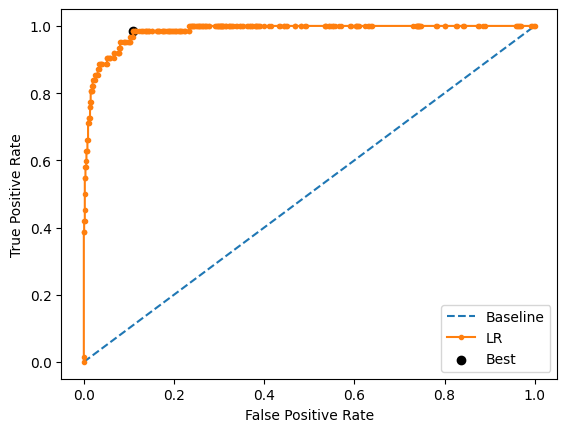

In [135]:
best_thresh=tuning(y55, LR_probac)

In [136]:
#Defining a function that displays probability thresholds by percentiles
def threshp():
    for i in np.arange(80, 100, 5):
        print("Top", 100-i, "% of predicted risk=", np.percentile(LR_probac, i) )

threshp()

Top 20 % of predicted risk= 0.05749016341769385
Top 15 % of predicted risk= 0.07264336090906255
Top 10 % of predicted risk= 0.08898368642033047
Top 5 % of predicted risk= 0.12359954055606223


In [137]:
yprob=cLR.predict_proba(X15)
yprob=yprob[:, 1]
print('Probs: %.3f (%.3f)' % (mean(yprob), std(yprob)) )

Probs: 0.044 (0.045)


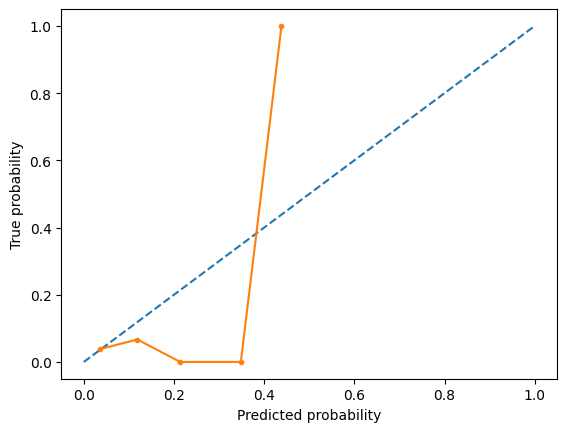

In [138]:
ccurve(y15, yprob)

In [139]:
eval(y15, yprob, best_thresh)


F1= 0.196078
Sensitivity= 0.454545
Specificity= 0.856557
AUROC= 0.784836


(0.196078431372549,
 0.7848360655737705,
 0.45454545454545453,
 0.8565573770491803)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

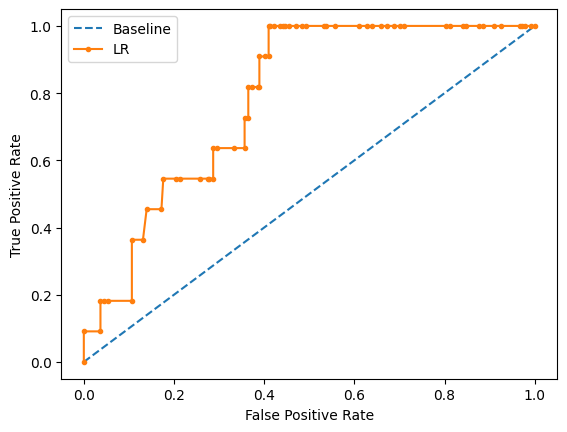

In [140]:
fpr, tpr, thresholds=roc_curve(y15, yprob)    
# plot the roc curve for the model, 
pyplot.plot([0,1], [0,1], linestyle='--', label='Baseline')
pyplot.plot(fpr, tpr, marker='.', label='LR')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
